In [1]:
import numpy as np
import cv2
import pandas as pd
from sklearn.metrics import accuracy_score
from lib.ReadFiles import read_csv
from lib.FaceDetection import find_faces
from lib.Prepocessing import image_equalizer
from lib.plot import *
from tensorflow.keras.models import load_model
import joblib

fisher = joblib.load("model/fisherface_training.pkl")
bpn = load_model("model/backprop_test.h5")

def reshape_dataset(X, y):
    images = [np.array(dx) for dx in X]
    images = np.asarray(images, dtype=np.uint8)
    labels = np.array(y).tolist()
    return images, labels
	
emotions = ["Marah", "Jijik", "Takut",
            "Senang", "Sedih", "Terkejut", "Biasa saja"]  # inisialisasi index dan emosi

In [2]:
_x, _y, _u = read_csv("input/fer2013_small.csv")
print(np.array(_x).shape)

x_new, y_new, u_new = [], [], []
for i, pixel in enumerate(_x):
	for norm, (x,y,w,h) in find_faces(np.array(pixel, dtype=np.uint8).reshape(48, 48)):
		if norm.size >0:
			x_new.append(pixel)
			y_new.append(_y[i])
			u_new.append(_u[i])
print(np.array(x_new).shape)

x_, y_ = image_equalizer(x_new, y_new)

(3815, 2304)
(1868, 2304)


In [3]:

dataframe = pd.DataFrame({"emotion": y_, "pixels": x_, "usage": u_new})

0.2571428571428571


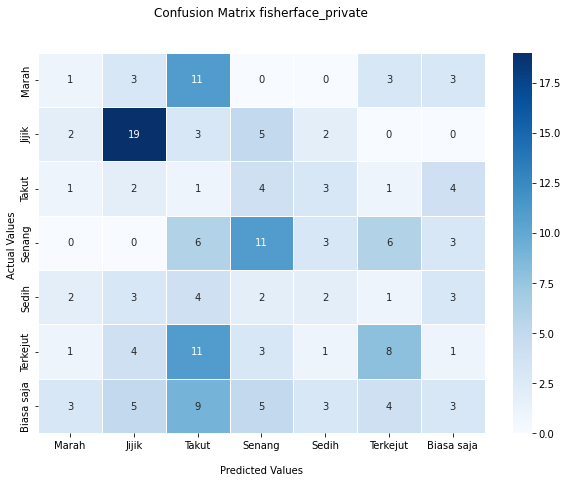

6/6 [==============================] - 0s 2ms/step - loss: 0.0229 - accuracy: 0.8857


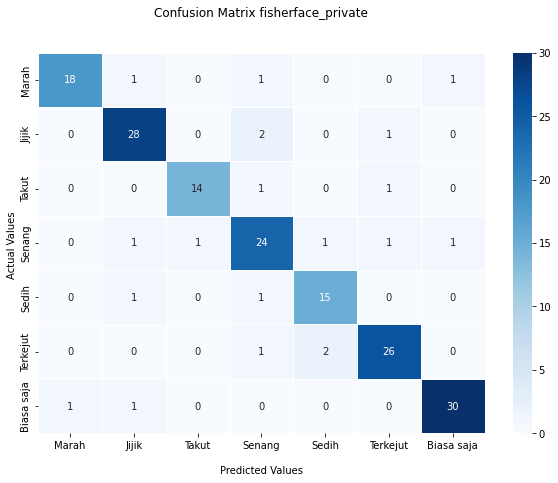

In [9]:
from tensorflow.keras.utils import to_categorical
_x_priv, _y_priv = dataframe.loc[dataframe["usage"] == "PrivateTest","pixels"], dataframe.loc[dataframe["usage"] == "PrivateTest", "emotion"]

x_priv, y_priv = reshape_dataset(_x_priv, _y_priv)

f_pred1 = []
f_extract1 = []
for i in range(len(x_priv)):
	_p = fisher.predict(x_priv[i]) #prediksi fisherface
	_q = fisher.extract(x_priv[i]) #ekstrasi fitur fisherface
	f_pred1.append(_p)
	f_extract1.append(_q)

print(accuracy_score(y_priv, f_pred1))
cm_plot(y_priv, f_pred1,'fisherface_private')

bpn.evaluate(np.asarray(f_extract1, dtype=np.float32).reshape(len(f_extract1), -1), to_categorical(y_priv))
bpn_pred1 = bpn.predict(np.asarray(f_extract1, dtype=np.float32).reshape(len(f_extract1), -1))
cm_plot(y_priv, np.argmax(bpn_pred1,axis=1),'fisherface_private')

0.2903225806451613


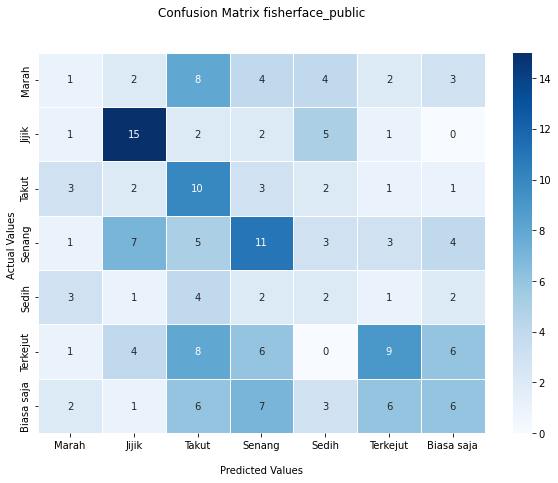

6/6 [==============================] - 0s 1ms/step - loss: 0.0206 - accuracy: 0.9032


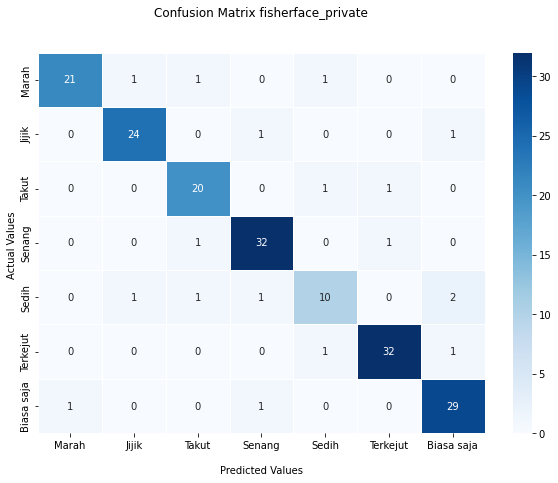

In [11]:
_x_pub, _y_pub = dataframe.loc[dataframe["usage"] == "PublicTest","pixels"], dataframe.loc[dataframe["usage"] == "PublicTest", "emotion"]

x_pub, y_pub = reshape_dataset(_x_pub, _y_pub)

f_pred2 = []
f_extract2 = []
for i in range(len(x_pub)):
	_p = fisher.predict(x_pub[i]) #prediksi fisherface
	_q = fisher.extract(x_pub[i]) #ekstrasi fitur fisherface
	f_pred2.append(_p)
	f_extract2.append(_q)

print(accuracy_score(y_pub, f_pred2))
cm_plot(y_pub, f_pred2, 'fisherface_public')

bpn.evaluate(np.asarray(f_extract2, dtype=np.float32).reshape(len(f_extract2), -1), to_categorical(y_pub))
bpn_pred2 = bpn.predict(np.asarray(f_extract2, dtype=np.float32).reshape(len(f_extract2), -1))
cm_plot(y_pub, np.argmax(bpn_pred2,axis=1),'fisherface_private')

0.15444015444015444


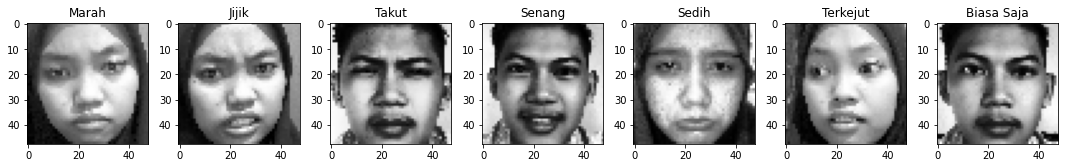

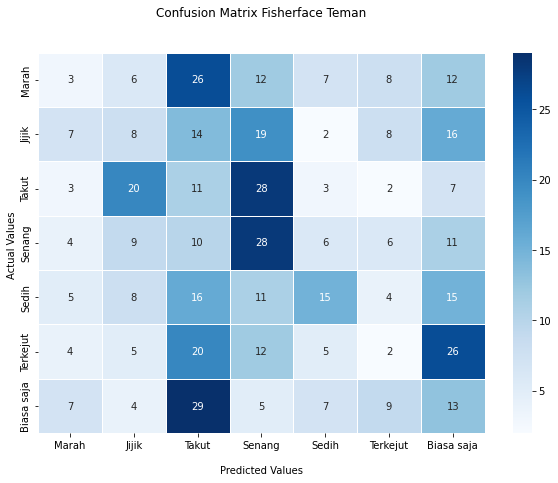

17/17 [==============================] - 0s 1ms/step - loss: 0.1888 - accuracy: 0.1409


[0.18881762027740479, 0.14092664420604706]

In [13]:
# membaca datatest Teman
_x_teman, _y_teman = read_csv("input/datatest_prib.csv")

x_teman, y_teman = reshape_dataset(_x_teman, _y_teman)

x_teman, y_teman = image_equalizer(x_teman, y_teman)
plot_figure(x_teman, y_teman)

f_pred3 = []
f_extract3 = []
for i in range(len(x_teman)):
	_p = fisher.predict(x_teman[i]) #prediksi fisherface
	_q = fisher.extract(x_teman[i]) #ekstrasi fitur fisherface
	f_pred3.append(_p)
	f_extract3.append(_q)

print(accuracy_score(y_teman, f_pred3))
cm_plot(y_teman, f_pred3, 'Fisherface Teman')

bpn.evaluate(np.asarray(f_extract3, dtype=np.float32).reshape(len(f_extract3), -1), to_categorical(y_teman))

17/17 [==============================] - 0s 1ms/step - loss: 0.1888 - accuracy: 0.1409


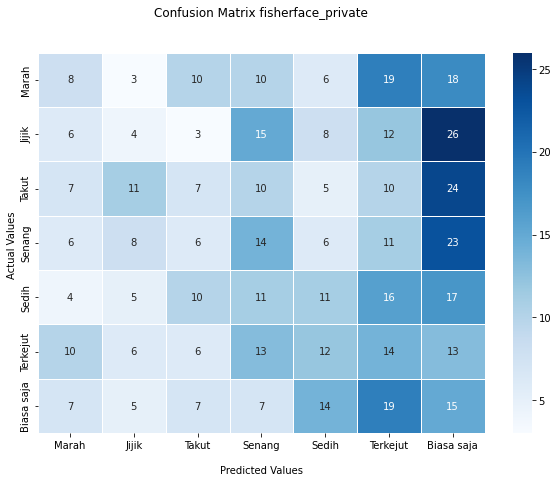

In [14]:
bpn.evaluate(np.asarray(f_extract3, dtype=np.float32).reshape(len(f_extract3), -1), to_categorical(y_teman))
bpn_pred3 = bpn.predict(np.asarray(f_extract3, dtype=np.float32).reshape(len(f_extract3), -1))
cm_plot(y_teman, np.argmax(bpn_pred3,axis=1),'fisherface_private')

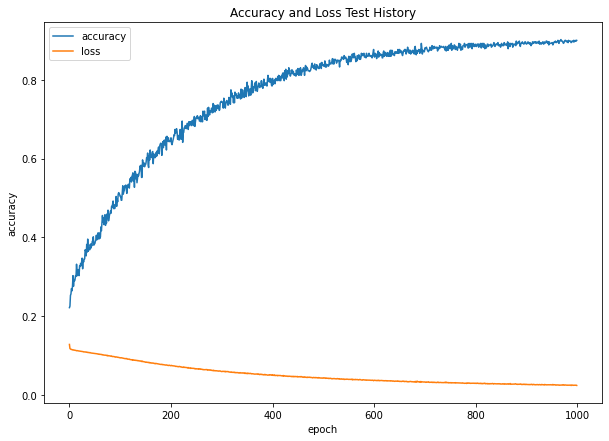

89.96139168739319


In [16]:
from lib.Backpropagation import ModelBackprop, normalize_data

bpn2 = ModelBackprop(x = f_extract3, y = y_teman, n_hidden=128, lr=0.25, path='model/backprop_teman.h5')
history_plot(bpn2.history, 'Test History', False)
f_tem, y_tem = normalize_data(f_extract3 ,y_teman)
(loss,accuracy) = bpn2.model.evaluate(f_tem, y_tem, verbose=0)
print(accuracy*100)


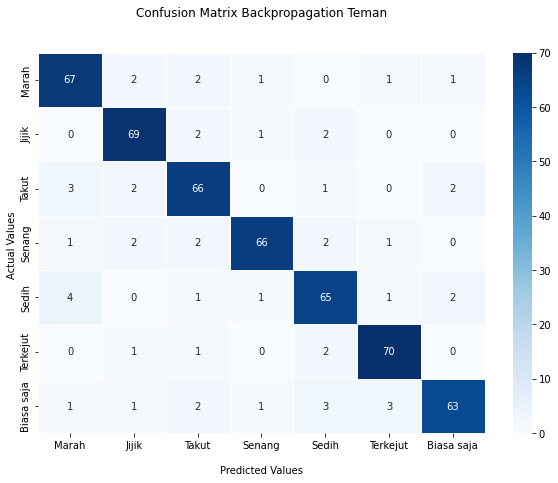

In [23]:
predict = bpn2.predict(f_extract3)
cm_plot(y_teman, np.argmax(predict, axis=1), 'Backpropagation Teman', False)